In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np

2024-09-05 19:12:50.619328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 19:12:50.619448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 19:12:50.759635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the source directories
train_dir = '/kaggle/input/plant-disease-recognition-dataset/Train/Train'
validation_dir = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation'
test_dir = '/kaggle/input/plant-disease-recognition-dataset/Test/Test'

# Define the destination directory
combined_dir = '/kaggle/working/Combined'

# Create the combined directory structure
os.makedirs(os.path.join(combined_dir, 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(combined_dir, 'Powdery'), exist_ok=True)
os.makedirs(os.path.join(combined_dir, 'Rust'), exist_ok=True)

# Function to copy images to the combined directory
def copy_images(src_dir, dst_dir):
    for label in ['Healthy', 'Powdery', 'Rust']:
        label_src_dir = os.path.join(src_dir, label)
        label_dst_dir = os.path.join(dst_dir, label)
        for filename in os.listdir(label_src_dir):
            src_file = os.path.join(label_src_dir, filename)
            dst_file = os.path.join(label_dst_dir, filename)
            shutil.copy(src_file, dst_file)

# Copy images from train and validation directories to combined directory
copy_images(train_dir, combined_dir)
copy_images(validation_dir, combined_dir)

# Function to count images in a directory
def count_images(directory):
    count = 0
    for label in ['Healthy', 'Powdery', 'Rust']:
        label_dir = os.path.join(directory, label)
        label_count = len(os.listdir(label_dir))
        count += label_count
        print(f'{label}: {label_count} images')
    return count

# Count images in the combined directory
print("Counting images in the combined directory:")
total_combined_images = count_images(combined_dir)
print(f'Total images in combined directory: {total_combined_images}')

# Count images in the test directory
print("\nCounting images in the test directory:")
total_test_images = count_images(test_dir)
print(f'Total images in test directory: {total_test_images}')

Counting images in the combined directory:
Healthy: 478 images
Powdery: 450 images
Rust: 454 images
Total images in combined directory: 1382

Counting images in the test directory:
Healthy: 50 images
Powdery: 50 images
Rust: 50 images
Total images in test directory: 150


In [3]:
# Define ImageDataGenerators for train and validation sets
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data will be used for validation
    horizontal_flip=True,
    zoom_range=0.3,
    shear_range=0.3,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = datagen.flow_from_directory(
    combined_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    combined_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Create a separate test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Correct directory for test images
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1107 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [4]:
# Build the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/34 ━━━━━━━━━━━━━━━━━━━━ 16:48 31s/step - accuracy: 0.3438 - loss: 3.2457

I0000 00:00:1725563646.383122     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3752 - loss: 2.8801 - val_accuracy: 0.7539 - val_loss: 1.7352 - learning_rate: 1.0000e-04
Epoch 2/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 2.3552

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5625 - loss: 2.3552 - val_accuracy: 0.8421 - val_loss: 1.5724 - learning_rate: 1.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5831 - loss: 2.2058 - val_accuracy: 0.9023 - val_loss: 1.4326 - learning_rate: 1.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6562 - loss: 2.2025 - val_accuracy: 0.9474 - val_loss: 1.3573 - learning_rate: 1.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7148 - loss: 1.8823 - val_accuracy: 0.9219 - val_loss: 1.3580 - learning_rate: 1.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8750 - loss: 1.5651 - val_accuracy: 0.9474 - val_loss: 1.3646 - learning_rate: 1.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7466 - loss: 1.8164 - val_accuracy: 0.9297 - val_loss: 1.3378 - learning_rate: 1.0000e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9062 - loss: 

In [6]:
# Evaluate the model with the correct test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

loss1, accuracy1 = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy1 * 100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9729 - loss: 1.2656
Test accuracy: 97.33%
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9413 - loss: 1.2601
Validation accuracy: 93.82%


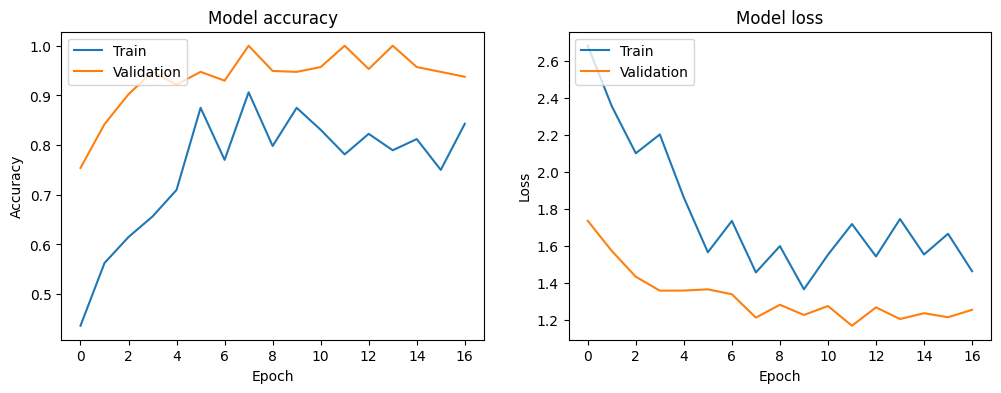

In [7]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [8]:
model = load_model('/kaggle/working/best_model.keras')

# Function to preprocess and predict
def predict_image(image_path, model, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale
    prediction = model.predict(img_array)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_indices[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence

# Example usage
image_path = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/Healthy/8eaeaea542a5217b.jpg'  # Replace with your image path
predicted_class, confidence = predict_image(image_path, model)
print(f'Predicted class: {predicted_class} with confidence: {confidence:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Healthy with confidence: 0.92


In [9]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-25:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
fine_tune_learning_rate = 1e-6
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[reduce_lr, early_stop, checkpoint]
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8116 - loss: 1.5659 - val_accuracy: 0.9531 - val_loss: 1.2557 - learning_rate: 1.0000e-06
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9062 - loss: 1.4128 - val_accuracy: 0.9474 - val_loss: 1.2759 - learning_rate: 1.0000e-06
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8385 - loss: 1.5823 - val_accuracy: 0.9492 - val_loss: 1.2831 - learning_rate: 1.0000e-06
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8750 - loss: 1.5317 - val_accuracy: 1.0000 - val_loss: 1.1864 - learning_rate: 1.0000e-06
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8144 - loss: 1.5500 - val_accuracy: 0.9648 - val_loss: 1.2248 - learning_rate: 1.0000e-06


In [10]:
# Evaluate the model after fine-tuning
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

loss1, accuracy1 = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy1 * 100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9729 - loss: 1.2658
Test accuracy: 97.33%
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9482 - loss: 1.2386
Validation accuracy: 94.55%


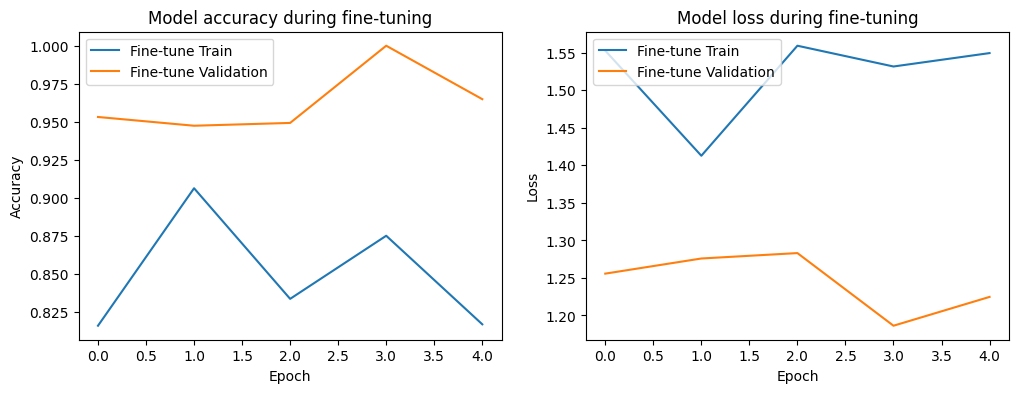

In [11]:
# Plot accuracy and loss for fine-tuning phase
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Fine-tune Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Model accuracy during fine-tuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Fine-tune Train', 'Fine-tune Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Fine-tune Train Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tune Validation Loss')
plt.title('Model loss during fine-tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Fine-tune Train', 'Fine-tune Validation'], loc='upper left')

plt.show()

In [12]:
# Function to preprocess and predict
def predict_image_ft(image_path, model, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale
    prediction = model.predict(img_array)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_indices[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence


image_path = '/kaggle/input/plant-disease-recognition-dataset/Test/Test/Healthy/8eaeaea542a5217b.jpg'  # Replace with your image path
predicted_class, confidence = predict_image_ft(image_path, model)
print(f'Predicted class: {predicted_class} with confidence: {confidence:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Healthy with confidence: 0.92
